In [1]:
# Importing Libraries..
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import nltk
import string
import re
from collections import Counter
# packages from gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# packages from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#packages from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import wordnet
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the training data..
df_train=pd.read_csv('train.csv')
df_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
#Import Test Dataset
df_test= pd.read_csv("test.csv")
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


There is no null values in the dataset and we can also see the datatypes of each column.

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


There is no null values in the test dataset and we can also see the datatypes of each column.

In [6]:
# checking the features,duplicate values and nan values in the Datasets

print("\nFeatures Present in the Dataset: \n", df_train.columns)
shape=df_train.shape
print("\nTotal Number of Rows : ",shape[0])
print("Total Number of Features : ", shape[1])
print("\n\nData Types of Features :\n", df_train.dtypes)
print("\nDataset contains any NaN/Empty cells : ", df_train.isnull().values.any())
print("\nTotal number of empty rows in each feature:\n", df_train.isnull().sum(),"\n\n")
print("Total number of unique values in each feature:")
for col in df_train.columns.values:
    print("Number of unique values of {} : {}".format(col, df_train[col].nunique()))


Features Present in the Dataset: 
 Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

Total Number of Rows :  159571
Total Number of Features :  8


Data Types of Features :
 id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

Dataset contains any NaN/Empty cells :  False

Total number of empty rows in each feature:
 id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64 


Total number of unique values in each feature:
Number of unique values of id : 159571
Number of unique values of comment_text : 159571
Number of unique values of malignant : 2
Number of unique values of highly_malignant : 2
Number

In [7]:
#Checking shape of dataset
df_train.shape

(159571, 8)

There are 159571 rows and 8 columns in the training dataset

In [8]:
#Checking shape of test dataset
df_test.shape

(153164, 2)

There are 153164 rows and 2 columns in the test dataset

In [9]:
# Lets see how the comments are 
df_train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [10]:
df_train['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

By observing these comments we can say that we need to do text processing as there are many words and numbers wich are not important for prediction.

# Exploratory Data Analysis

In [11]:
# Let's check the average and maximum length of a comment

lens = df_train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.138847284281, 590.7253812496405, 5000)

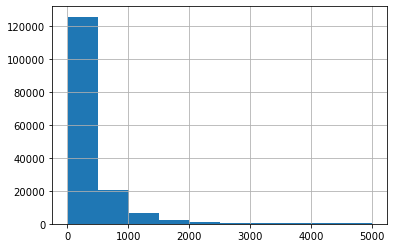

In [12]:
# Let's Plot the length in a histogram

lens.hist();

In [13]:
# Let's plot the correlation chart

df_train.corr().style.background_gradient(cmap='YlGnBu')


,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


<AxesSubplot:>

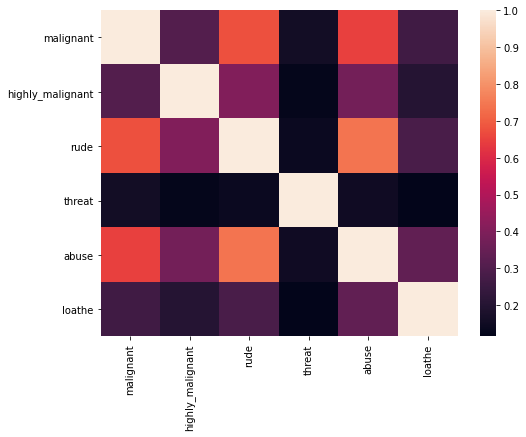

In [14]:
# Let's view the Correlation heatmap among variables
plt.figure(figsize=(8,6))
sns.heatmap(df_train.corr())

In [15]:
features=df_train.columns[1:]

In [16]:
#checking count of Positive and Negative comments in each category
for i in features:
    print('Number of unique values in {} : {}'.format(i, df_train[i].value_counts()))

Number of unique values in comment_text : Yeh \n\nAnd you too!!!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [17]:
#Checking percentage of good and bad comments in dataset
good_comments = df_train[(df_train['malignant']!=1) & (df_train['highly_malignant']!=1) & (df_train['rude']!=1) & 
                            (df_train['threat']!=1) & (df_train['abuse']!=1) & (df_train['loathe']!=1)]
good_percent=len(good_comments)/len(df_train)*100
print('Percentage of good comments = ',good_percent)
print('Percentage of negative comments = ', (100-good_percent))

Percentage of good comments =  89.83211235124176
Percentage of negative comments =  10.167887648758239


In [18]:
# Adding new column comment_length to check length of comment_text characters

df_train['comment_length']=df_train.comment_text.str.len()
df_train

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [19]:
# Creating a new feature having Negative Comments and Non-Negative Comments from all features combinly.
df_train['label'] = df_train[features].max(axis=1)
df_train.head(10)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,65,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,115,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,472,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,70,0


In [20]:
df_train['label'].value_counts()

24      629
34      628
32      617
31      615
33      609
       ... 
2539      1
4712      1
3269      1
3419      1
4585      1
Name: label, Length: 4048, dtype: int64

In [21]:
# Create a bar graph 
sum_mal = df_train['malignant'].sum() / len(df_train) * 100
sum_hig = df_train['highly_malignant'].sum() / len(df_train) * 100
sum_rude = df_train['rude'].sum() / len(df_train) * 100
sum_thr = df_train['threat'].sum() / len(df_train) * 100
sum_abu = df_train['abuse'].sum() / len(df_train) * 100
sum_loa = df_train['loathe'].sum() / len(df_train) * 100

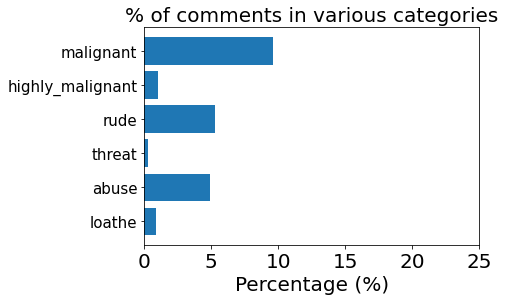

In [22]:
# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_mal, sum_hig, sum_rude, sum_thr, sum_abu, sum_loa])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=20)
plt.yticks(ind, ('malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe' ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()

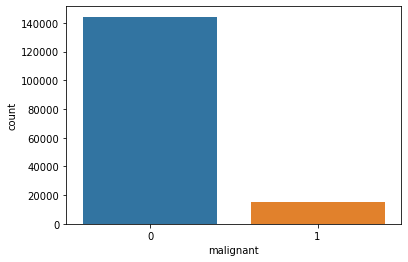

0    144277
1     15294
Name: malignant, dtype: int64


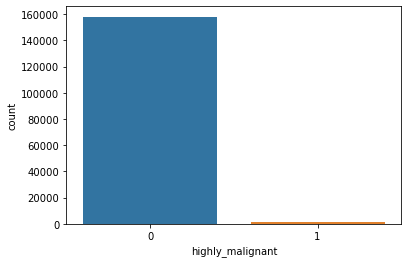

0    157976
1      1595
Name: highly_malignant, dtype: int64


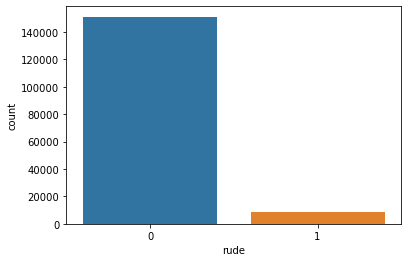

0    151122
1      8449
Name: rude, dtype: int64


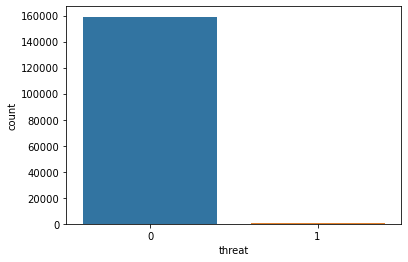

0    159093
1       478
Name: threat, dtype: int64


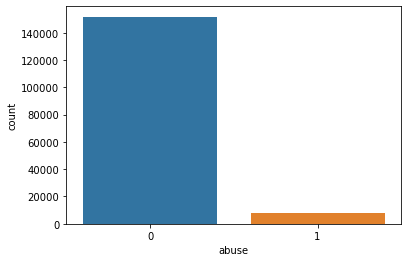

0    151694
1      7877
Name: abuse, dtype: int64


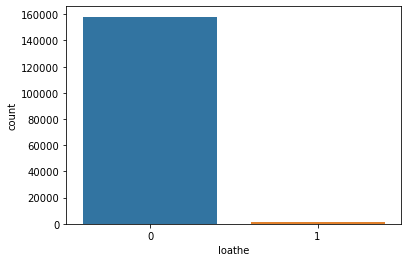

0    158166
1      1405
Name: loathe, dtype: int64


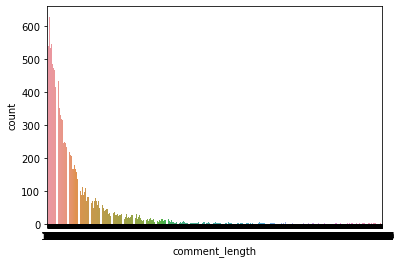

24      629
34      628
32      617
31      615
33      609
       ... 
2539      1
4712      1
3269      1
3419      1
4585      1
Name: comment_length, Length: 4048, dtype: int64


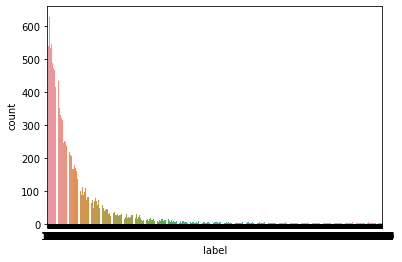

24      629
34      628
32      617
31      615
33      609
       ... 
2539      1
4712      1
3269      1
3419      1
4585      1
Name: label, Length: 4048, dtype: int64


In [23]:
for columns in df_train.iloc[:,2:]:
    sns.countplot(df_train[columns])
    plt.show()
    print(df_train[columns].value_counts())

In [24]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count_new = df_train.iloc[:,2:].sum()

In [25]:
# Checking the percentage of comments that are toxic
df_train.malignant.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: malignant, dtype: float64

So more than 90% comments are malignant in nature.

In [26]:
data_count_new

malignant              15294
highly_malignant        1595
rude                    8449
threat                   478
abuse                   7877
loathe                  1405
comment_length      62893130
label                  16225
dtype: int64

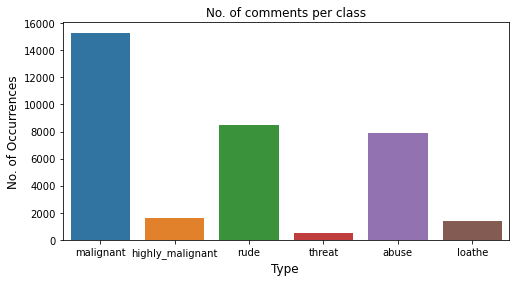

In [27]:
data_count = df_train.iloc[:,2:8].sum()
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category.
ax = sns.barplot(data_count.index, data_count.values)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
plt.show()

In [28]:
#creating three different columns length, exclamation and question based on conditions
def feature_engg(df):
    
    df['length'] = df.comment_text.apply(lambda x: len(x))

    df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))

    df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))

    # Normalization
    for label in ['length','question', 'exclamation']:
        minimum = df[label].min()
        diff = df[label].max() - minimum
        df[label] = df[label].apply(lambda x: (x-minimum) / (diff))

feature_engg(df_train)
df_train.head()        

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length,label,length,exclamation,question
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,0,0.051852,0.000000,0.004785
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,0,0.021421,0.000202,0.000000
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,0,0.045646,0.000000,0.000000
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,0,0.123524,0.000000,0.000000
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,0,0.012412,0.000000,0.004785


# Text processing:

In [29]:
#function for lemmatization
def lemm(text):
    lemmatizer = wordnet.WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(word, wn.VERB) for word in word_tokens]
    
    return " ".join(lemmas)

#function for removing stopwords    
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in string.punctuation]
    filtered_text = [word for word in filtered_text if word not in stop_words]
    return " ".join(filtered_text)

def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"yo", "you",text)
    text = re.sub(r"youu", "you",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

def text_proc(df):
    
    df['comment_text'] = df.comment_text.apply(lambda x: x.lower()) #lowering all text
    df['comment_text'] = df.comment_text.apply(lambda x: re.sub(r'\d+','',x)) #removing numbers
    df['comment_text'] = df.comment_text.apply(lambda x: re.sub(r'\n',' ',x)) #removing \n
    df['comment_text'] = df.comment_text.apply(lambda x: decontracted(x))
    df['comment_text'] = df.comment_text.apply(lambda x: lemm(x))
    
    #removing punctuations
    translator = str.maketrans('','', string.punctuation)
    df['comment_text'] = df.comment_text.apply(lambda x : x.translate(translator))
    df['comment_text'] = df.comment_text.apply(lambda x: rem_stopwords(x))

text_proc(df_train)
df_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length,label,length,exclamation,question
0,0000997932d777bf,explanation edit make username hardcore metall...,0,0,0,0,0,0,264,0,0.051852,0.000000,0.004785
1,000103f0d9cfb60f,daww match background colour seemingly stick t...,0,0,0,0,0,0,112,0,0.021421,0.000202,0.000000
2,000113f07ec002fd,hey man really try edit war guy constantly rem...,0,0,0,0,0,0,233,0,0.045646,0.000000,0.000000
3,0001b41b1c6bb37e,make real suggestions amprovement wonder secti...,0,0,0,0,0,0,622,0,0.123524,0.000000,0.000000
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,67,0,0.012412,0.000000,0.004785


In [10]:
#function for lemmatization
def lemm(text):
    lemmatizer = wordnet.WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(word, wn.VERB) for word in word_tokens]
    
    return " ".join(lemmas)

#function for removing stopwords    
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in string.punctuation]
    filtered_text = [word for word in filtered_text if word not in stop_words]
    return " ".join(filtered_text)

def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"yo", "you",text)
    text = re.sub(r"youu", "you",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

def text_proc(df):
    
    df['comment_text'] = df.comment_text.apply(lambda x: x.lower()) #lowering all text
    df['comment_text'] = df.comment_text.apply(lambda x: re.sub(r'\d+','',x)) #removing numbers
    df['comment_text'] = df.comment_text.apply(lambda x: re.sub(r'\n',' ',x)) #removing \n
    df['comment_text'] = df.comment_text.apply(lambda x: decontracted(x))
    df['comment_text'] = df.comment_text.apply(lambda x: lemm(x))
    
    #removing punctuations
    translator = str.maketrans('','', string.punctuation)
    df['comment_text'] = df.comment_text.apply(lambda x : x.translate(translator))
    df['comment_text'] = df.comment_text.apply(lambda x: rem_stopwords(x))

text_proc(df_train)
df_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,length,exclamation,question
0,0000997932d777bf,explanation edit make username hardcore metall...,0,0,0,0,0,0,0.051852,0.000000,0.004785
1,000103f0d9cfb60f,daww match background colour seemingly stick t...,0,0,0,0,0,0,0.021421,0.000202,0.000000
2,000113f07ec002fd,hey man really try edit war guy constantly rem...,0,0,0,0,0,0,0.045646,0.000000,0.000000
3,0001b41b1c6bb37e,make real suggestions amprovement wonder secti...,0,0,0,0,0,0,0.123524,0.000000,0.000000
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,0.012412,0.000000,0.004785


In [30]:
#checking the value counts of id column
df_train.id.value_counts()

33ba627a102cf3d7    1
eca8b4d59df00f98    1
256fbb5af924d4cf    1
2b192149c5e26fff    1
3ace39a71c72ed71    1
                   ..
3a61a7673aa63646    1
de2a9079d4d87927    1
c784c74592ea7a94    1
722c0d306335799c    1
948056427f52225d    1
Name: id, Length: 159571, dtype: int64

As the column id is having unique entries for every row we don't need this column for prediction. So I'm dropping it here itself.

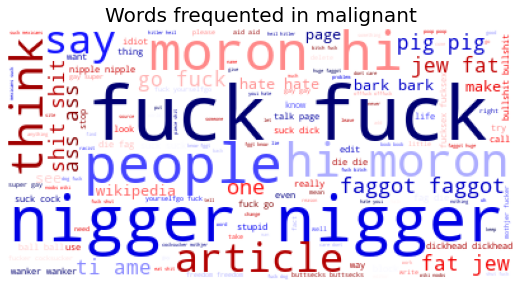

In [32]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="white",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'seismic_r' , random_state=244))
df_mal = df_train.loc[:,['id','comment_text','malignant']]
wordcloud(df_mal, 'malignant')

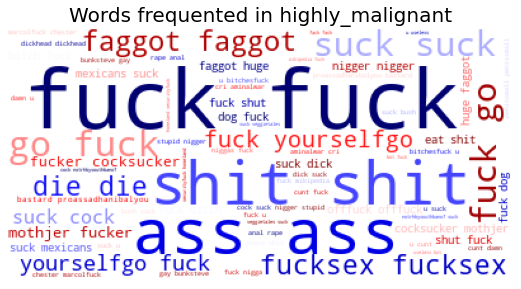

In [33]:
df_H_mal = df_train.loc[:,['id','comment_text','highly_malignant']]
wordcloud(df_H_mal, 'highly_malignant')

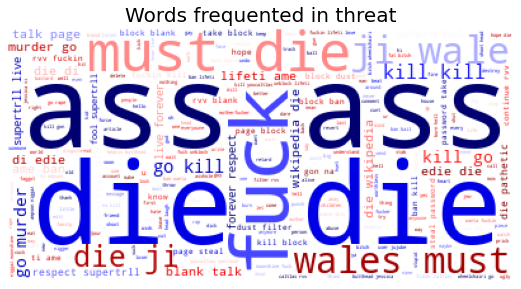

In [34]:
df_thr = df_train.loc[:,['id','comment_text','threat']]
wordcloud(df_thr, 'threat')


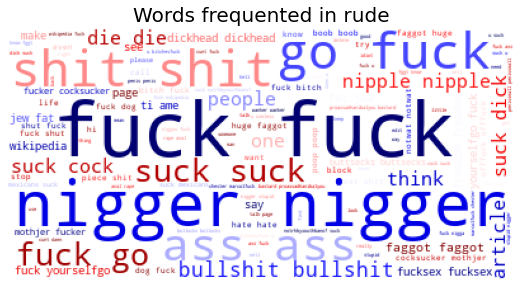

In [35]:
df_rud = df_train.loc[:,['id','comment_text','rude']]
wordcloud(df_rud, 'rude')

# Model Building

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

tfidf = TfidfVectorizer(analyzer='word',max_features=4000)
y = df_train.drop(columns = ['id','comment_text','length','exclamation','question','comment_length','label'])
x = tfidf.fit_transform(df_train.comment_text)

#lets check the shape of x and y
x.shape, y.shape

((159571, 4000), (159571, 6))

In [38]:
#adding remaining features to x
length = []
exclamation = []
question = []

for i in df_train.length:
    length.append([i])
for i in df_train.exclamation:
    exclamation.append([i])
for i in df_train.question:
    question.append([i])
import scipy as sp
X = sp.sparse.hstack((x, length, exclamation, question))
X.shape, y.shape

((159571, 4003), (159571, 6))

In [41]:
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier

# Model selection libraries...
from sklearn.model_selection import cross_val_score as cvs, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV


# Importing some metrics we can use to evaluate our model performance.... 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix, jaccard_score, hamming_loss
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import log_loss


#splitting the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

#!pip install wheel
#!pip install lightgbm

from sklearn.multiclass import OneVsRestClassifier

# Creating instances for different Classifiers
svc = LinearSVC()
lr = LogisticRegression(solver='lbfgs')
mnb = MultinomialNB()
lgb = LGBMClassifier()
sgd = SGDClassifier()
pac=PassiveAggressiveClassifier()

#function for printing score
def print_score(y_pred,clf):
    print('classifier:',clf.__class__.__name__)
    print("Jaccard score: {}".format(jaccard_score(y_test,y_pred,average='micro')))
    print("Accuracy score: {}".format(accuracy_score(y_test,y_pred)))
    print("f1_score: {}".format(f1_score(y_test,y_pred,average='micro')))
    print("Precision : ", precision_score(y_test,y_pred,average='micro'))
    print("Recall: {}".format(recall_score(y_test,y_pred,average='micro')))
    print("Hamming loss: ", hamming_loss(y_test,y_pred))
    print("Confusion matrix:\n ", multilabel_confusion_matrix(y_test,y_pred))
    print('========================================\n')    
    
#models with evaluation using OneVsRestClassifier
for classifier in [svc,lr,mnb,lgb,sgd,pac,dt]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    print_score(y_pred, classifier)

classifier: LinearSVC
Jaccard score: 0.5454731248722665
Accuracy score: 0.9194595543077733
f1_score: 0.7058979106056599
Precision :  0.8490536026721807
Recall: 0.6040511485798348
Hamming loss:  0.018583042973286876
Confusion matrix:
  [[[35693   385]
  [ 1267  2548]]

 [[39421    66]
  [  305   101]]

 [[37589   161]
  [  695  1448]]

 [[39769    19]
  [   82    23]]

 [[37611   271]
  [  872  1139]]

 [[39489    47]
  [  278    79]]]

classifier: LogisticRegression
Jaccard score: 0.5223303001778057
Accuracy score: 0.9198355601233299
f1_score: 0.6862246650635521
Precision :  0.8733823015040224
Recall: 0.565123910829467
Hamming loss:  0.01908020621830062
Confusion matrix:
  [[[35821   257]
  [ 1430  2385]]

 [[39416    71]
  [  290   116]]

 [[37620   130]
  [  774  1369]]

 [[39781     7]
  [   92    13]]

 [[37650   232]
  [  960  1051]]

 [[39509    27]
  [  297    60]]]

classifier: MultinomialNB
Jaccard score: 0.43888415672913117
Accuracy score: 0.9130925224976812
f1_score: 0.61003

The accuracy of all models is 90+% which is quite good.

In [43]:
#Putting Scikit-Learn machine learning Models in a list so that it can be used for further evaluation in loop.
models=[]
models.append(('LinearSVC',svc))
models.append(('LogisticRegression',lr))
models.append(('MultinomialNB',mnb))
models.append(('LGBMClassifier',lgb))
models.append(('SGDClassifier',sgd))
models.append(('PassiveAggressiveClassifier',pac))

#Lists to store model name, cross_val_score, Auc Roc score .
Model=[]
cvscore=[]
rocscore=[]
lg_loss=[]

#For Loop to Calculate Accuracy Score, Cross Val Score, Classification Report, Confusion Matrix

for name,model in models:
    print('***************************',name,'*****************************')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
    
#................Finding Cross_val_score..................    
    cv_score=cvs(model,x,y,cv=10,scoring='roc_auc').mean()
    print('Cross Val Score : ', cv_score)
    cvscore.append(cv_score*100)
    
    
    loss = log_loss(y_test,y_pred)
    print('Log loss : ', loss)
    lg_loss.append(loss)
    print('\n')

*************************** LinearSVC *****************************


LinearSVC()


Cross Val Score :  nan
Log loss :  1.7016222269790673


*************************** LogisticRegression *****************************


LogisticRegression()


Cross Val Score :  nan
Log loss :  1.7016222269790673


*************************** MultinomialNB *****************************


MultinomialNB()


Cross Val Score :  nan
Log loss :  1.7016222269790673


*************************** LGBMClassifier *****************************


LGBMClassifier()


Cross Val Score :  nan
Log loss :  1.7016222269790673


*************************** SGDClassifier *****************************


SGDClassifier()


Cross Val Score :  nan
Log loss :  1.7016222269790673


*************************** PassiveAggressiveClassifier *****************************


PassiveAggressiveClassifier()


Cross Val Score :  nan
Log loss :  1.7016222269790673




# Hyperparameter Tuning:

In [44]:
param = {
        'estimator__penalty': ['l1'],
        'estimator__loss': ['hinge','squared_hinge'],
        'estimator__multi_class': ['ovr','crammer_singer'],
        'estimator__dual': [False],
        'estimator__intercept_scaling': [2,4,5],
        'estimator__C': [2]
        }
#train the model with given parameters using GridSearchCV
svc = OneVsRestClassifier(LinearSVC())
GCV =  GridSearchCV(svc,param,cv = 3, verbose =0,n_jobs=-1)
GCV.fit(x_train,y_train)

#printing the best parameters found by GridSearchCV
GCV.best_params_

{'estimator__C': 2,
 'estimator__dual': False,
 'estimator__intercept_scaling': 4,
 'estimator__loss': 'squared_hinge',
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l1'}

# Final Model

In [45]:
finalmodel = OneVsRestClassifier(LinearSVC(C=2,dual = False, loss='squared_hinge',multi_class='ovr', penalty ='l1',intercept_scaling=4))
finalmodel.fit(x_train,y_train)
y_pred = finalmodel.predict(x_test)

print("Jaccard score: {}".format(jaccard_score(y_test,y_pred,average='micro')))
print("Accuracy score: {}".format(accuracy_score(y_test,y_pred)))
print("f1_score: {}".format(f1_score(y_test,y_pred,average='micro')))
print("Precision : ", precision_score(y_test,y_pred,average='micro'))
print("Recall: {}".format(recall_score(y_test,y_pred,average='micro')))
print("Hamming loss: ", hamming_loss(y_test,y_pred))
print("\nConfusion matrix: \n", multilabel_confusion_matrix(y_test,y_pred))

finalmodel.predict(X)

Jaccard score: 0.5499033472377658
Accuracy score: 0.9195848895796255
f1_score: 0.7095969541814362
Precision :  0.8449273096764108
Recall: 0.611632907095168
Hamming loss:  0.018482774755805113

Confusion matrix: 
 [[[35680   398]
  [ 1239  2576]]

 [[39413    74]
  [  295   111]]

 [[37581   169]
  [  682  1461]]

 [[39763    25]
  [   76    29]]

 [[37605   277]
  [  873  1138]]

 [[39487    49]
  [  267    90]]]


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Model Saving

In [46]:
import joblib
joblib.dump(finalmodel,"Malignant_comment.pkl")
#loading the model
model = joblib.load('Malignant_comment.pkl')

# Prediction for test dataset using final model

In [47]:
#feature engineering
feature_engg(df_test) 

#processing the test data set
text_proc(df_test)   

tfidf = TfidfVectorizer(analyzer = 'word', max_features=4000)
X = tfidf.fit_transform(df_test.comment_text)
length = []
exclamation = []
question = []
source = []
for i in df_test.length:
    length.append([i])
for i in df_test.exclamation:
    exclamation.append([i])
for i in df_test.question:
    question.append([i])

import scipy as sp
X_test = sp.sparse.hstack((X, length, exclamation, question))

#lets predict the output
finalmodel.predict(X_test)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [48]:
predictions = finalmodel.predict(X_test)
pred=pd.DataFrame(predictions, columns = ['malignant','highly_malignant','rude','threat','abuse','loathe'])
pred

,malignant,highly_malignant,rude,threat,abuse,loathe
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
153159,0,0,0,0,0,0
153160,0,0,0,0,0,0
153161,0,0,0,0,0,0
153162,0,0,0,0,0,0


In [50]:
x_test_pred = pd.concat([df_test,pred], axis=1)
x_test_pred

,id,comment_text,length,exclamation,question,malignant,highly_malignant,rude,threat,abuse,loathe
0,00001cee341fdb12,bitch ja rule succesful ever whats hat sad mof...,0.073215,0.0,0.000000,0,0,0,0,0,0
1,0000247867823ef7,rfc title fine amo,0.009802,0.0,0.000000,0,0,0,0,0,0
2,00013b17ad220c46,source zawe ashton lapland —,0.010602,0.0,0.000000,0,0,0,0,0,0
3,00017563c3f7919a,look back source information update correct fo...,0.040808,0.0,0.000000,0,0,0,0,0,0
4,00017695ad8997eb,anonymously edit article,0.008002,0.0,0.000000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,totally agree stuff nothing toolongcrap,0.011802,0.0,0.000000,0,0,0,0,0,0
153160,fffd7a9a6eb32c16,throw field home plate get faster throw cut ma...,0.039408,0.0,0.001736,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,okinotorishi ama categories see change agree c...,0.084417,0.0,0.000868,0,0,0,0,0,0
153162,fffe8f1340a79fc2,one found nations eu germany law return quite ...,0.100220,0.0,0.000868,0,0,0,0,0,0


In [51]:
#saving the data into csv file
x_test_pred.to_csv("malignant_test_predictions.csv")